In [3]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [4]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3,dirichlet, neumann

In [5]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

In [6]:
def grad_eta_j(i,summets):
    x1 = summets[0][0]
    x2 = summets[1][0]
    x3 = summets[2][0]
    y1 = summets[0][1]
    y2 = summets[1][1]
    y3 = summets[2][1]
    T= np.array([[x1,x2,x3],[y1,y2,y3]])
    alpha=np.linalg.det(np.array([(x2-x1,x3-x1),(y2 -y1,y3-y1)]))
    r = np.multiply((1/alpha),np.array([T[1,(i+1)%3]-T[1,(i+2)%3],T[0,(i+2)%3]-T[0,(i+1)%3]]))
    return r





def raideur_triangle(liste_indices_sommets,coordonnees_sommets):
    liste_indices_sommets=[0,1,2]
    res = np.zeros((3,3))
    x1 = coordonnees_sommets[0][0]
    x2 = coordonnees_sommets[1][0]
    x3 = coordonnees_sommets[2][0]
    y1 = coordonnees_sommets[0][1]
    y2 = coordonnees_sommets[1][1]
    y3 = coordonnees_sommets[2][1]
    alpha=np.linalg.det(np.array([(x2-x1,x3-x1),(y2 -y1,y3-y1)]))
    T = (0.5)*alpha


    for i in range(3):
        for j in range(3):
            res[i][j] += np.dot(np.transpose(grad_eta_j(liste_indices_sommets[i],coordonnees_sommets)), \
                                grad_eta_j(liste_indices_sommets[j],coordonnees_sommets))
    return np.multiply(T,res)

def assemblageA(n):
    con, ele3n, dirin, neun = maillage(n)

    A=np.zeros((n*n,n*n))

    for sommets in ele3n:
        coord = np.array([con[sommets[0]], con[sommets[1]], con[sommets[2]]])
        M = raideur_triangle(sommets,coord)
        for i in range(3):
            for j in range(3):
                A[sommets[i]][sommets[j]] += M[i][j]
        
    
    return A 

In [7]:
import itertools
def assemblageB_elementaire(n,f,x1,x2,x3,y1,y2,y3):
    xg=(x1+x2+x3)/3
    yg=(y1+y2+y3)/3
    alpha=(x2-x1)*(y3-y1)-(y2-y1)*(x3-x1)
    return (alpha/6)*f(xg,yg)
    
def assemblageB(n,f):
    con, ele3n, dirin, neun = maillage(n)

    m=2*(n-1)*(n-1)
    b=np.zeros((n*n,1))
    for k in range(m):
        
        (x1,y1)=(con[ele3n[k,0],0],con[ele3n[k,0],1])
        (x2,y2)=(con[ele3n[k,1],0],con[ele3n[k,1],1])
        (x3,y3)=(con[ele3n[k,2],0],con[ele3n[k,2],1])
        for i in range(3):
            b[ele3n[k,i]]+=assemblageB_elementaire(n,f,x1,x2,x3,y1,y2,y3)
    return b

In [8]:
#resolution de l'équation

def resolution_equation(n,f,ud):
    con, ele3n, dirin, neun = maillage(n)
    x = np.zeros((n*n,1))
    A = assemblageA(n)
    b = assemblageB(n,f)
    ldiri = dirin.tolist()
    lsommets = [ i for i in range(n*n)]
    for k in ldiri:
        lsommets.remove(k[0])

    o = len(lsommets)
    A_int = np.zeros((o,o))
    for t in range(o):
        for r in range(o):
            A_int[t,r] = A[lsommets[t],lsommets[r]]
    b_int = b[lsommets].reshape((n*n-len(ldiri),1))
    x_int = np.linalg.solve(A_int, b_int)
    x[lsommets] = x_int
    for k in range(ud.shape[0]):
        x[ldiri[k]] = ud[k]
    return x



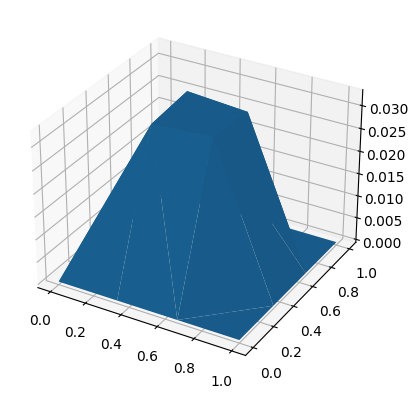

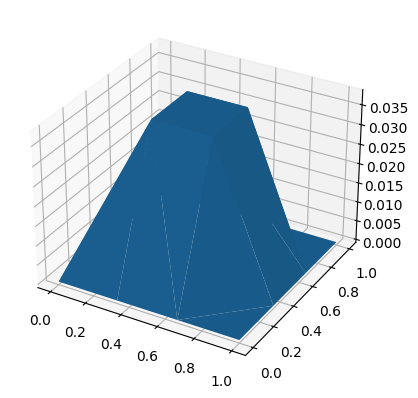

In [9]:
def f(x,y):
    return (math.sin(math.pi*x)*math.sin(math.pi*y))

def solution_theo(x,y):
    return (math.sin(math.pi*x)*math.sin(math.pi*y))/(2*math.pi**2)



con, ele3n, dirin, neun = maillage(4)
s = dirin.shape[0]
ud = np.array(np.zeros((s,1)))
u = resolution_equation(4,f,ud)
liste_de_valeurs = []
for i in range(u.shape[0]):
    liste_de_valeurs.append(u[i,0])
mat_solution = np.array((liste_de_valeurs))
show(con,mat_solution)
#comparaison avec solution theorique
vecteur_theo = []
for i in range(u.shape[0]):
    vecteur_theo.append(solution_theo(con[i,0],con[i,1]))
mat_solution = np.array((vecteur_theo))
show(con,vecteur_theo)

**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [10]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])
liste_sommets_neu = [4,5,6,0,1,2]

In [11]:
##  partie 2


# La matrice de raideur en utilisant le maillage carré

def Raideur_carre(x,y):
    MQ=np.zeros((4,4))
    Jaco_phi=np.array([[x[1]-x[0],x[3]-x[0]],[y[1]-y[0],y[3]-y[0]]])
    determinant=np.linalg.det(Jaco_phi)  
    J=np.linalg.inv(Jaco_phi*np.transpose(Jaco_phi))
    (a,b,c)=(J[0,0],J[0,1],J[1,1])
    return (determinant/6)*np.array([[2*a+3*b+2*c,-2*a+c,-a-3*b-c,a-2*c],[-2*a+c,2*a-3*b+2*c,a-2*c,-a+3*b-c],
                                     [-a-3*b-c,a-2*c,2*a+3*b+2*c,-2*a+c],[a-2*c,-a+3*b-c,-2*a+c,2*a-3*b+2*c]])
    
def assemblage_eta1(n, coo, ele4):
    m=np.shape(ele4)[0]
    A= np.zeros((n*n,n*n))
    for k in range(m):
        (x1,y1)=(coo[ele4[k,0],0],coo[ele4[k,0],1])
        (x2,y2)=(coo[ele4[k,1],0],coo[ele4[k,1],1])
        (x3,y3)=(coo[ele4[k,2],0],coo[ele4[k,2],1])
        (x4,y4)=(coo[ele4[k,3],0],coo[ele4[k,3],1])
        x=[x1,x2,x3,x4]
        y=[y1,y2,y3,y4]
        for i in range(4) :
            for j in range(4):
                A[ele4[k,i],ele4[k,j]]=A[ele4[k,i],ele4[k,j]]+Raideur_carre(x,y)[i,j]
    return A

 

def assemblage_eta2(n,f,ud,g,coo,ele3,ele4,diri,neu):
    #retour:
    #x = le vecteur solution rempli par les valeur solution sur les sommets de dirirchlet et neumann
    #b = la second terme final pour la restitution des valeurs intérieures
    #A: la matrice de formulation variationnelle
    #calcul du second membre b
    b=np.zeros((n*n,1))
    m=np.shape(ele4)[0]
    A = assemblage_eta1(n,coo,ele4)
    for k in range(m):
        (x0,y0)=(coo[ele4[k,0],0],coo[ele4[k,0],1])
        (x2,y2)=(coo[ele4[k,2],0],coo[ele4[k,2],1])
        (x1,y1)=(coo[ele4[k,1],0],coo[ele4[k,1],1])
        (x3,y3)=(coo[ele4[k,3],0],coo[ele4[k,3],1])
        xg=(x1+x0+x2+x3)/4
        yg=(y1+y2+y3+y0)/4
        Jaco_phi=np.array([[x1-x0,x3-x0],[y1-y0,y3-y0]])
        alpha=np.linalg.det(Jaco_phi) 
        for i in range(4):
            for j in range(4):
                b[ele4[k,i]]+=(alpha/4)*f(xg,yg)

        p = np.shape(ele3)[0]
        for k in range(p):
            (x1,y1) = (coo[ele3[k,0],0],coo[ele3[k,0],1])
            (x2,y2) = (coo[ele3[k,1],0],coo[ele3[k,1],1])
            (x3,y3) = (coo[ele3[k,2],0],coo[ele3[k,2],1])
            alpha = np.linalg.det(np.array([[x2-x1,x3-x1], [y2-y1,y3-y1]]))
            xG = (x1+x2+x3)/3 
            yG = (y1+y2+y3)/3
            summets = np.array(([x1,y1],[x2,y2],[x3,y3]))
            for i in range(3):
                for j in range(3):
                    b[ele3[k,i]] += (alpha/6)*f(xG,yG)
                    t = grad_eta_j(i,summets)
                    q = grad_eta_j(j,summets)
                    A[ele3[k,i],ele3[k,j]] += (1/(2*alpha))*np.dot(np.transpose(t),q)
    
    #prendre en compte les conditions de dirichlet
    #x contiendra notre solution
    #ici on restitue les condition de dirichlet
    x = np.zeros((n**2,1))
    for i in diri:
        x[i] = ud(coo[i,0],coo[i,1])

    #####################################################to do##############################################

    #il nous reste la restitution des condition de neumann dans le vecteur x
    #formellement on est censé effectué ici : 
    # x[sommets_de_neumann] = [les valeur de la solution sur les sommets de neumann]
    #difficulté rencontrée: tirer u de drond(u)/drond(n)
    
    for h in liste_sommets_neu:
        #calcul de la valeur de la solution sur le sommet de neumann h
        # to do
        ##################
        x[h] = h
    #######################################################################################################

    #retirer les conditions de dirichlet (éventuellement de neumann aussi si on les avait faites)
    b = b - A.dot(x)
    for i,j in neu:
        (x1,y1) = (coo[i,0],coo[i,1])
        (x2,y2) = (coo[j,0],coo[j,1])
        length = (np.sqrt((x1-x2)**2 + (y1-y2)**2))
        xG = (x1+x2)/2
        yG = (y1+y2)/2
        b[i] +=  (length/2)*g(xG,yG)
        b[j] +=  (length/2)*g(xG,yG)
    return b,x,A

 

In [12]:
def resolutio_equation2(n,f,ud, g, coordonnees, ele3, ele4, dirich,neumann):
    b,x,A = assemblage_eta2(n,f,ud,g,coordonnees,ele3,ele4,dirich,neumann)
    y = np.linalg.solve(A, b)
    ldiri = dirich.tolist()
    lsommets_interieurs = [i for i in range(n*n)]
    for k in ldiri:
        lsommets_interieurs.remove(k)
    for h in liste_sommets_neu:
        if h in lsommets_interieurs :
            lsommets_interieurs.remove(h)
    x[lsommets_interieurs] = y[lsommets_interieurs]
    return x

C:\Users\33665\AppData\Roaming\Python\Python310\site-packages\matplotlib\tri\_triangulation.py:179: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)


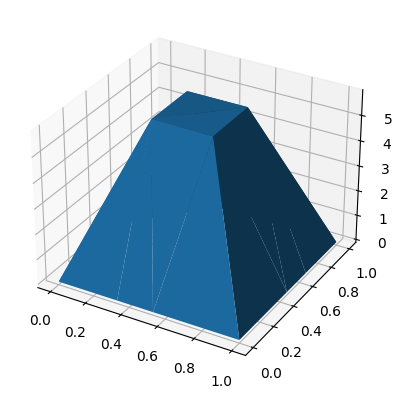

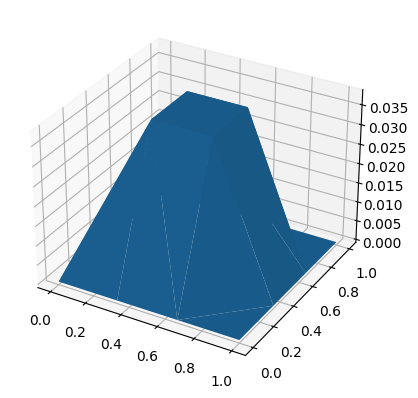

In [13]:
def g(abcisse,ordonnee):
    return 1
def ud(ab,ord):
    return 0

n = 4
x = resolutio_equation2(n,f,ud, g, ccs, e3, e4, dds,nns)
liste_de_valeurs = []
for i in range(x.shape[0]):
    liste_de_valeurs.append(x[i,0])

mat_solution = np.array((liste_de_valeurs))
show(ccs,mat_solution)
#comparaison avec solution theorique
show(con,vecteur_theo)


**Compléments  :  un nouveau terme dans l'EDP**  (voir le rapport aussi) 

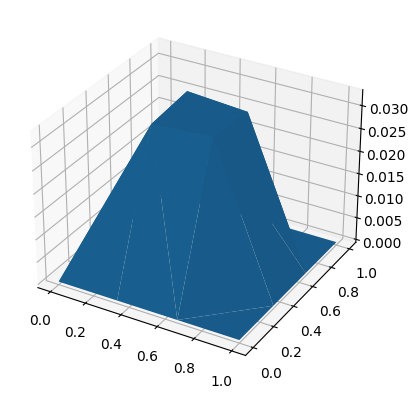

In [21]:

#Complements
#Analyse de la formulation variationnelle discrète
c0=1
Eta=np.array([[1/12,1/24,1/24],[1/24,1/12,1/24],[1/24,1/24,1/24]])

def assemblageA_c0(n):
    con, ele3n, dirin, neun = maillage(n)

    A=np.zeros((n*n,n*n))

    for sommets in ele3n:
        coord = np.array([con[sommets[0]], con[sommets[1]], con[sommets[2]]])
        x1 = con[sommets[0]][0]
        x2 = con[sommets[1]][0]
        x3 = con[sommets[2]][0]
        y1 = con[sommets[0]][1]
        y2 = con[sommets[1]][1]
        y3 = con[sommets[2]][1]
        alpha=np.linalg.det(np.array([(x2-x1,x3-x1),(y2 -y1,y3-y1)]))
        M = raideur_triangle(sommets,coord)
        for i in range(3):
            for j in range(3):
                A[sommets[i]][sommets[j]] += M[i][j] + c0*alpha*Eta[i,j]
        
    
    return A 

def resolution_equation_c0(n,f,ud):
    con, ele3n, dirin, neun = maillage(n)
    x = np.zeros((n*n,1))
    A = assemblageA_c0(n)
    b = assemblageB(n,f)
    ldiri = dirin.tolist()
    lsommets = [ i for i in range(n*n)]
    for k in ldiri:
        lsommets.remove(k[0])

    o = len(lsommets)
    A_int = np.zeros((o,o))
    for t in range(o):
        for r in range(o):
            A_int[t,r] = A[lsommets[t],lsommets[r]]
    b_int = b[lsommets].reshape((n*n-len(ldiri),1))
    x_int = np.linalg.solve(A_int, b_int)
    x[lsommets] = x_int
    for k in range(ud.shape[0]):
        x[ldiri[k]] = ud[k]
    return x

con, ele3n, dirin, neun = maillage(4)
s = dirin.shape[0]
ud = np.array(np.zeros((s,1)))
u = resolution_equation(4,f,ud)
liste_de_valeurs = []
for i in range(u.shape[0]):
    liste_de_valeurs.append(u[i,0])
mat_solution = np.array((liste_de_valeurs))
show(con,mat_solution)
      
